In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

def plot_rota_particula(coords, vetor_posicao, titulo='Rota da Partícula'):
    rota = np.argsort(vetor_posicao)
    caminho = coords[rota]
    caminho = np.vstack([caminho, caminho[0]])
    plt.figure(figsize=(8, 6))
    plt.plot(caminho[:, 0], caminho[:, 1], '-o', markersize=5)
    plt.title(titulo)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')
    plt.show()


with open("data/att48.tsp", "r") as f:
    lines = f.readlines()

coords = []
start = False
for line in lines:
    if "NODE_COORD_SECTION" in line:
        start = True
        continue
    if start:
        if "EOF" in line or line.strip() == "":
            break
        parts = re.findall(r"[\d\.\-]+", line)
        if len(parts) >= 3:
            coords.append((float(parts[1]), float(parts[2])))

coords = np.array(coords)

n_cidades = len(coords)
dist_matrix = np.zeros((n_cidades, n_cidades))

for i in range(n_cidades):
    for j in range(n_cidades):
        if i != j:
            dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])


Inicialização do enxame

## PSO

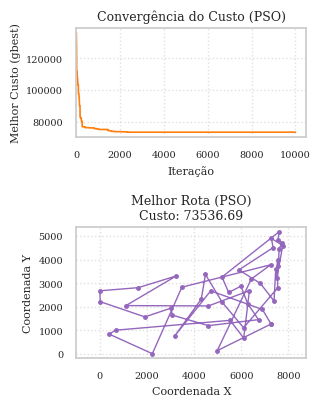

Gráfico combinado do PSO (1 coluna) salvo em 'images' como images/pso_custo_rota_1col_ieee.pdf e .png


In [56]:
n_particulas = 30
enxame = []

for _ in range(n_particulas):
    posicao = np.random.rand(n_cidades)
    velocidade = np.random.uniform(-0.1, 0.1, size=n_cidades)
    rota = np.argsort(posicao)
    custo = sum(dist_matrix[rota[i], rota[(i + 1) % n_cidades]] for i in range(n_cidades))

    particula = {
        'posicao': posicao,
        'velocidade': velocidade,
        'pbest': posicao.copy(),
        'pbest_custo': custo
    }

    enxame.append(particula)

gbest = min(enxame, key=lambda p: p['pbest_custo'])
gbest_pos = gbest['pbest'].copy()
gbest_custo = gbest['pbest_custo']

n_iter = 10000


c1 = 1.8
c2 = 1.5

w_max = 0.9
w_min = 0.6

historico_gbest = []
iter_atual = 0

for iter_atual_loop in range(n_iter):
    w = w_max - (w_max - w_min) * (iter_atual_loop / n_iter)

    for p in enxame:
        r1_vec = np.random.rand(n_cidades)
        r2_vec = np.random.rand(n_cidades)

        termo_inercia = w * p['velocidade']
        termo_cognitivo = c1 * r1_vec * (p['pbest'] - p['posicao'])
        termo_social = c2 * r2_vec * (gbest_pos - p['posicao'])

        p['velocidade'] = termo_inercia + termo_cognitivo + termo_social

        p['posicao'] += p['velocidade']
        
        p['posicao'] = np.clip(p['posicao'], 0.0, 1.0)

        rota = np.argsort(p['posicao'])
        custo = sum(dist_matrix[rota[i], rota[(i + 1) % n_cidades]] for i in range(n_cidades))

        if custo < p['pbest_custo']:
            p['pbest'] = p['posicao'].copy()
            p['pbest_custo'] = custo

    melhor_particula_iter = min(enxame, key=lambda p: p['pbest_custo'])
    if melhor_particula_iter['pbest_custo'] < gbest_custo:
        gbest_custo = melhor_particula_iter['pbest_custo']
        gbest_pos = melhor_particula_iter['pbest'].copy()

    if historico_gbest:
        historico_gbest.append(min(gbest_custo, historico_gbest[-1]))
    else:
        historico_gbest.append(gbest_custo)

# --- Importações e Configurações para Plots IEEE (como você já tem) ---
import matplotlib.pyplot as plt
import numpy as np # Garanta que numpy está importado
import os

# Configurações IEEE
largura_uma_coluna_ieee_pol = 3.4

# Tamanhos de fonte
fonte_titulo_fig = 10
fonte_titulo_sub = 9
fonte_rotulo_eixo = 8
fonte_ticks = 7
# plt.rcParams['font.family'] = 'serif' # Se estiver usando
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

pasta_imagens = "images"
if not os.path.exists(pasta_imagens):
    os.makedirs(pasta_imagens)

# --- Figura Combinada: Convergência do Custo e Melhor Rota Final (PARA PSO) ---

# Verifica se os dados necessários do PSO existem
if ('historico_gbest' in locals() and historico_gbest and
    'gbest_pos' in locals() and gbest_pos is not None and
    'coords' in locals() and coords.any() and
    'gbest_custo' in locals() and gbest_custo is not None and not np.isinf(gbest_custo) and
    'n_cidades' in locals()): # n_cidades é importante para PSO

    altura_total_fig_pso = 4.5 # Ajuste esta altura conforme necessário
    fig_pso, axes_pso = plt.subplots(
        2, 1,
        figsize=(largura_uma_coluna_ieee_pol, altura_total_fig_pso),
        gridspec_kw={'height_ratios': [1, 1.2]}
    )

    # Título da figura opcional
    # fig_pso.suptitle('Análise do PSO', fontsize=fonte_titulo_fig, y=0.99)

    # --- Subplot 1 (Superior): Convergência do Custo (PSO) ---
    ax_custo_pso = axes_pso[0]
    ax_custo_pso.plot(historico_gbest, color='tab:orange', linewidth=1.2) # Cor diferente para PSO
    ax_custo_pso.set_title('Convergência do Custo (PSO)', fontsize=fonte_titulo_sub)
    ax_custo_pso.set_xlabel('Iteração', fontsize=fonte_rotulo_eixo) # PSO usa iterações
    ax_custo_pso.set_ylabel('Melhor Custo (gbest)', fontsize=fonte_rotulo_eixo)
    ax_custo_pso.grid(True, linestyle=':', alpha=0.6)
    ax_custo_pso.tick_params(axis='both', labelsize=fonte_ticks)
    ax_custo_pso.set_xlim(left=0)
    # ax_custo_pso.locator_params(axis='y', nbins=5)
    # ax_custo_pso.locator_params(axis='x', nbins=5)


    # --- Subplot 2 (Inferior): Melhor Rota Final (PSO) ---
    ax_rota_pso = axes_pso[1]
    
    # Para PSO, a rota é derivada da gbest_pos
    if len(gbest_pos) != n_cidades:
        print(f"Erro PSO: Tamanho de gbest_pos ({len(gbest_pos)}) não corresponde a n_cidades ({n_cidades}). Plot da rota não gerado.")
        # Pode-se optar por mostrar apenas o gráfico de custo se a rota falhar
        ax_rota_pso.set_title("Melhor Rota (PSO)\nErro: dados inválidos", fontsize=fonte_titulo_sub)
        ax_rota_pso.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_pso.transAxes)
        ax_rota_pso.set_xticks([])
        ax_rota_pso.set_yticks([])
    else:
        rota_final_pso = np.argsort(gbest_pos)
        
        # Verificação adicional do tamanho da rota derivada
        if len(rota_final_pso) != coords.shape[0]:
             print(f"Erro PSO: Tamanho da rota_final_pso ({len(rota_final_pso)}) não corresponde ao número de cidades em coords ({coords.shape[0]}).")
             ax_rota_pso.set_title("Melhor Rota (PSO)\nErro: dados inválidos", fontsize=fonte_titulo_sub)
             ax_rota_pso.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_pso.transAxes)
             ax_rota_pso.set_xticks([])
             ax_rota_pso.set_yticks([])
        else:
            try:
                caminho_final_pso = coords[rota_final_pso]
                caminho_final_pso = np.vstack([caminho_final_pso, caminho_final_pso[0]])

                ax_rota_pso.plot(caminho_final_pso[:, 0], caminho_final_pso[:, 1], '-o', markersize=2.5, linewidth=1.0, color='tab:purple') # Cor diferente
                titulo_rota_pso = f"Melhor Rota (PSO)\nCusto: {gbest_custo:.2f}"
                ax_rota_pso.set_title(titulo_rota_pso, fontsize=fonte_titulo_sub)
                ax_rota_pso.set_xlabel("Coordenada X", fontsize=fonte_rotulo_eixo)
                ax_rota_pso.set_ylabel("Coordenada Y", fontsize=fonte_rotulo_eixo)
                ax_rota_pso.tick_params(axis='both', labelsize=fonte_ticks)
                ax_rota_pso.grid(True, linestyle=':', alpha=0.6)
                ax_rota_pso.axis('equal')
                # ax_rota_pso.locator_params(axis='y', nbins=4)
                # ax_rota_pso.locator_params(axis='x', nbins=4)
            except IndexError as e:
                print(f"Erro de Indexação ao gerar caminho para PSO: {e}. Verifique 'rota_final_pso' e 'coords'.")
                print(f"  rota_final_pso: {rota_final_pso[:10]}... (len: {len(rota_final_pso)})")
                print(f"  coords.shape: {coords.shape}")
                ax_rota_pso.set_title("Melhor Rota (PSO)\nErro: indexação", fontsize=fonte_titulo_sub)
                ax_rota_pso.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_pso.transAxes)
                ax_rota_pso.set_xticks([])
                ax_rota_pso.set_yticks([])


    fig_pso.tight_layout(rect=[0, 0.03, 1, 0.97]) 

    nome_arquivo_pso = os.path.join(pasta_imagens, "pso_custo_rota_1col_ieee")
    plt.savefig(f"{nome_arquivo_pso}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"{nome_arquivo_pso}.png", dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Gráfico combinado do PSO (1 coluna) salvo em '{pasta_imagens}' como {nome_arquivo_pso}.pdf e .png")
else:
    print("Não foi possível gerar o gráfico combinado para o PSO: dados não disponíveis ou inválidos.")
    if not ('historico_gbest' in locals() and historico_gbest): print("  > 'historico_gbest' não encontrado ou vazio.")
    if not ('gbest_pos' in locals() and gbest_pos is not None): print("  > 'gbest_pos' não encontrado ou é None.")
    if not ('coords' in locals() and coords.any()): print("  > 'coords' não encontrado ou vazio.")
    if not ('gbest_custo' in locals() and gbest_custo is not None and not np.isinf(gbest_custo)): print(f"  > 'gbest_custo' não encontrado, é None ou Inf: {gbest_custo if 'gbest_custo' in locals() else 'N/A'}")
    if not ('n_cidades' in locals()): print("  > 'n_cidades' não encontrado.")


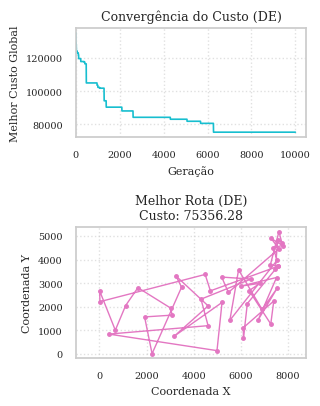

Gráfico combinado do DE (1 coluna) salvo em 'images' como images/de_custo_rota_1col_ieee.pdf e .png


In [55]:
n_populacao = 30
n_iter = 10000
F = 0.5
CR = 0.9
lambda_param = 0.1

populacao = []
for _ in range(n_populacao):
    individuo_pos = np.random.rand(n_cidades)
    rota = np.argsort(individuo_pos)
    custo = sum(dist_matrix[rota[i], rota[(i + 1) % n_cidades]] for i in range(n_cidades))
    populacao.append({'posicao': individuo_pos, 'custo': custo})

melhor_global = min(populacao, key=lambda ind: ind['custo'])
gbest_pos = melhor_global['posicao'].copy()
gbest_custo = melhor_global['custo']

historico_gbest = [gbest_custo]

for geracao in range(n_iter):
    nova_populacao = []
    for i in range(n_populacao):
        alvo = populacao[i]

        idxs = [idx for idx in range(n_populacao) if idx != i]
        np.random.shuffle(idxs)
        if len(idxs) < 2: # Precisamos apenas de r2 e r3 distintos de i e entre si
            vetor_mutante = alvo['posicao'].copy()
        else:
            r2_idx, r3_idx = idxs[0], idxs[1] # idxs já não contém i
            b_de, c_de = populacao[r2_idx], populacao[r3_idx] # Renomeado para não conflitar
            vetor_mutante = alvo['posicao'] + lambda_param * (gbest_pos - alvo['posicao']) + F * (b_de['posicao'] - c_de['posicao'])
            vetor_mutante = np.clip(vetor_mutante, 0.0, 1.0)

        # if len(idxs) < 3:
        #     vetor_mutante = alvo['posicao'].copy()
        # else:
        #     a, b, c = populacao[idxs[0]], populacao[idxs[1]], populacao[idxs[2]]
        #     vetor_mutante = a['posicao'] + F * (b['posicao'] - c['posicao'])
        #     vetor_mutante = np.clip(vetor_mutante, 0.0, 1.0)

        vetor_ensaio = np.zeros_like(alvo['posicao'])
        j_rand = np.random.randint(0, n_cidades)

        for j in range(n_cidades):
            if np.random.rand() < CR or j == j_rand:
                vetor_ensaio[j] = vetor_mutante[j]
            else:
                vetor_ensaio[j] = alvo['posicao'][j]
        
        rota_ensaio = np.argsort(vetor_ensaio)
        custo_ensaio = sum(dist_matrix[rota_ensaio[k], rota_ensaio[(k + 1) % n_cidades]] for k in range(n_cidades))

        if custo_ensaio < alvo['custo']:
            nova_populacao.append({'posicao': vetor_ensaio, 'custo': custo_ensaio})
            if custo_ensaio < gbest_custo:
                gbest_custo = custo_ensaio
                gbest_pos = vetor_ensaio.copy()
        else:
            nova_populacao.append(alvo)

    populacao = nova_populacao

    historico_gbest.append(gbest_custo)

# --- Importações e Configurações para Plots IEEE (como você já tem) ---
import matplotlib.pyplot as plt
import numpy as np # Garanta que numpy está importado
import os

# Configurações IEEE
largura_uma_coluna_ieee_pol = 3.4

# Tamanhos de fonte
fonte_titulo_fig = 10
fonte_titulo_sub = 9
fonte_rotulo_eixo = 8
fonte_ticks = 7
# plt.rcParams['font.family'] = 'serif' # Se estiver usando
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

pasta_imagens = "images"
if not os.path.exists(pasta_imagens):
    os.makedirs(pasta_imagens)

# --- Figura Combinada: Convergência do Custo e Melhor Rota Final (PARA DE) ---

# Verifica se os dados necessários do DE existem
# Assumindo que 'n_cidades' e 'coords' são definidos externamente ao snippet do DE
if ('historico_gbest' in locals() and historico_gbest and
    'gbest_pos' in locals() and gbest_pos is not None and
    'coords' in locals() and coords.any() and # Assumindo que 'coords' existe
    'gbest_custo' in locals() and gbest_custo is not None and not np.isinf(gbest_custo) and
    'n_cidades' in locals()): # Assumindo que 'n_cidades' existe

    altura_total_fig_de = 4.5 # Ajuste esta altura conforme necessário
    fig_de, axes_de = plt.subplots(
        2, 1,
        figsize=(largura_uma_coluna_ieee_pol, altura_total_fig_de),
        gridspec_kw={'height_ratios': [1, 1.2]}
    )

    # Título da figura opcional
    # fig_de.suptitle('Análise da Evolução Diferencial (DE)', fontsize=fonte_titulo_fig, y=0.99)

    # --- Subplot 1 (Superior): Convergência do Custo (DE) ---
    ax_custo_de = axes_de[0]
    # O historico_gbest do seu DE já inclui o custo inicial, então o comprimento é n_iter + 1
    # Se quiser que o eixo x vá de 0 a n_iter, pode precisar ajustar o range do plot
    # ou plotar historico_gbest como está e o eixo x irá até len(historico_gbest)-1
    geracoes_plot = range(len(historico_gbest)) # Gerações de 0 até n_iter
    ax_custo_de.plot(geracoes_plot, historico_gbest, color='tab:cyan', linewidth=1.2) # Cor diferente para DE
    ax_custo_de.set_title('Convergência do Custo (DE)', fontsize=fonte_titulo_sub)
    ax_custo_de.set_xlabel('Geração', fontsize=fonte_rotulo_eixo) # DE usa gerações
    ax_custo_de.set_ylabel('Melhor Custo Global', fontsize=fonte_rotulo_eixo)
    ax_custo_de.grid(True, linestyle=':', alpha=0.6)
    ax_custo_de.tick_params(axis='both', labelsize=fonte_ticks)
    ax_custo_de.set_xlim(left=0)
    # ax_custo_de.locator_params(axis='y', nbins=5)
    # ax_custo_de.locator_params(axis='x', nbins=5)


    # --- Subplot 2 (Inferior): Melhor Rota Final (DE) ---
    ax_rota_de = axes_de[1]
    
    # Para DE (baseado no seu código), gbest_pos é um vetor de posições, similar ao PSO
    if len(gbest_pos) != n_cidades:
        print(f"Erro DE: Tamanho de gbest_pos ({len(gbest_pos)}) não corresponde a n_cidades ({n_cidades}). Plot da rota não gerado.")
        ax_rota_de.set_title("Melhor Rota (DE)\nErro: dados inválidos", fontsize=fonte_titulo_sub)
        ax_rota_de.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_de.transAxes)
        ax_rota_de.set_xticks([])
        ax_rota_de.set_yticks([])
    else:
        rota_final_de = np.argsort(gbest_pos)
        
        if len(rota_final_de) != coords.shape[0]:
             print(f"Erro DE: Tamanho da rota_final_de ({len(rota_final_de)}) não corresponde ao número de cidades em coords ({coords.shape[0]}).")
             ax_rota_de.set_title("Melhor Rota (DE)\nErro: dados inválidos", fontsize=fonte_titulo_sub)
             ax_rota_de.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_de.transAxes)
             ax_rota_de.set_xticks([])
             ax_rota_de.set_yticks([])
        else:
            try:
                caminho_final_de = coords[rota_final_de]
                caminho_final_de = np.vstack([caminho_final_de, caminho_final_de[0]])

                ax_rota_de.plot(caminho_final_de[:, 0], caminho_final_de[:, 1], '-o', markersize=2.5, linewidth=1.0, color='tab:pink') # Cor diferente
                titulo_rota_de = f"Melhor Rota (DE)\nCusto: {gbest_custo:.2f}"
                ax_rota_de.set_title(titulo_rota_de, fontsize=fonte_titulo_sub)
                ax_rota_de.set_xlabel("Coordenada X", fontsize=fonte_rotulo_eixo)
                ax_rota_de.set_ylabel("Coordenada Y", fontsize=fonte_rotulo_eixo)
                ax_rota_de.tick_params(axis='both', labelsize=fonte_ticks)
                ax_rota_de.grid(True, linestyle=':', alpha=0.6)
                ax_rota_de.axis('equal')
                # ax_rota_de.locator_params(axis='y', nbins=4)
                # ax_rota_de.locator_params(axis='x', nbins=4)
            except IndexError as e:
                print(f"Erro de Indexação ao gerar caminho para DE: {e}. Verifique 'rota_final_de' e 'coords'.")
                print(f"  rota_final_de: {rota_final_de[:10]}... (len: {len(rota_final_de)})")
                print(f"  coords.shape: {coords.shape}")
                ax_rota_de.set_title("Melhor Rota (DE)\nErro: indexação", fontsize=fonte_titulo_sub)
                ax_rota_de.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_de.transAxes)
                ax_rota_de.set_xticks([])
                ax_rota_de.set_yticks([])

    fig_de.tight_layout(rect=[0, 0.03, 1, 0.97]) 

    nome_arquivo_de = os.path.join(pasta_imagens, "de_custo_rota_1col_ieee")
    plt.savefig(f"{nome_arquivo_de}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"{nome_arquivo_de}.png", dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Gráfico combinado do DE (1 coluna) salvo em '{pasta_imagens}' como {nome_arquivo_de}.pdf e .png")
else:
    print("Não foi possível gerar o gráfico combinado para o DE: dados não disponíveis ou inválidos.")
    # Adicione impressões de debug para as variáveis do DE se necessário
    if not ('historico_gbest' in locals() and historico_gbest): print("  > DE: 'historico_gbest' não encontrado ou vazio.")
    if not ('gbest_pos' in locals() and gbest_pos is not None): print("  > DE: 'gbest_pos' não encontrado ou é None.")
    # ... e assim por diante para as outras variáveis do DE ...


In [11]:
import numpy as np
import random


def calcular_custo_rota(rota, dist_matrix):
    custo = 0
    for i in range(len(rota)):
        cidade_atual = rota[i]
        proxima_cidade = rota[(i + 1) % len(rota)]
        custo += dist_matrix[cidade_atual, proxima_cidade]
    return custo

def calcular_limites_custo(dist_matrix, n_cidades):
    custo_min_possivel = 0
    custo_max_possivel = 0
    for i in range(n_cidades):
        col_sem_zeros = dist_matrix[i, dist_matrix[i, :] > 0]
        if len(col_sem_zeros) > 0:
            custo_min_possivel += np.min(col_sem_zeros) if len(col_sem_zeros) > 0 else 0
        custo_max_possivel += np.max(dist_matrix[i, :]) if np.max(dist_matrix[i, :]) > 0 else 0
    return custo_min_possivel, custo_max_possivel

# --- Operadores Genéticos ---
def selecao_torneio(populacao_com_fitness, k=2):
    selecionados = []
    for _ in range(len(populacao_com_fitness)):
        participantes = random.sample(populacao_com_fitness, k)
        vencedor = min(participantes, key=lambda x: x['fitness_escalonada']) # Minimizando fitness escalonada
        selecionados.append(vencedor['individuo'])
    return selecionados

def crossover_pmx(pai1, pai2):
    n = len(pai1)
    filho1, filho2 = [-1]*n, [-1]*n
    
    ponto1, ponto2 = sorted(random.sample(range(n), 2))

    mapeamento1, mapeamento2 = {}, {}
    
    for i in range(ponto1, ponto2 + 1):
        filho1[i] = pai1[i]
        filho2[i] = pai2[i]
        mapeamento1[pai1[i]] = pai2[i]
        mapeamento2[pai2[i]] = pai1[i]

    for i in list(range(ponto1)) + list(range(ponto2 + 1, n)):
        val_pai2 = pai2[i]
        while val_pai2 in mapeamento1:
            val_pai2 = mapeamento1[val_pai2]
        filho1[i] = val_pai2

        val_pai1 = pai1[i]
        while val_pai1 in mapeamento2:
            val_pai1 = mapeamento2[val_pai1]
        filho2[i] = val_pai1
        
    return list(filho1), list(filho2)

def mutacao_swap(individuo):
    idx1, idx2 = random.sample(range(len(individuo)), 2)
    individuo[idx1], individuo[idx2] = individuo[idx2], individuo[idx1]
    return individuo

def mutacao_insert(individuo):
    idx1, idx2 = sorted(random.sample(range(len(individuo)), 2))
    cidade_movida = individuo.pop(idx2)
    individuo.insert(idx1, cidade_movida)
    return individuo

def mutacao_inversion(individuo):
    idx1, idx2 = sorted(random.sample(range(len(individuo)), 2))
    if idx1 == idx2: return individuo # Evita inversão de um único elemento
    segmento = individuo[idx1:idx2+1]
    segmento.reverse()
    individuo[idx1:idx2+1] = segmento
    return individuo


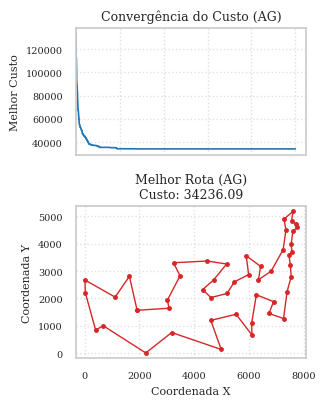

Gráfico combinado do AG (Custo e Rota, 1 coluna) salvo em 'images' como images/ag_custo_rota_1col_ieee.pdf e .png


In [86]:
n_populacao_ag = 70
n_geracoes_ag = 10000
taxa_crossover_ag = 0.8
taxa_mutacao_ag = 0.1
k_torneio = 2

custo_min_teorico, custo_max_teorico = calcular_limites_custo(dist_matrix, n_cidades)
if custo_min_teorico == custo_max_teorico:
    custo_max_teorico = custo_min_teorico + 1 

populacao_ag = []
for _ in range(n_populacao_ag):
    individuo = list(np.random.permutation(n_cidades))
    populacao_ag.append(individuo)

melhor_individuo_global_ag = None
melhor_custo_global_ag = float('inf')
melhor_fitness_global_ag = float('inf') 
historico_melhor_custo_ag = []
historico_melhor_fitness_esc_ag = [] 

for geracao in range(n_geracoes_ag):
    populacao_com_custos = []
    for ind in populacao_ag:
        custo = calcular_custo_rota(ind, dist_matrix)
        populacao_com_custos.append({'individuo': ind, 'custo_real': custo})

    populacao_com_fitness_escalonada = []
    melhor_custo_da_geracao_atual = float('inf')
    fitness_do_melhor_da_geracao_atual = float('inf')

    for item in populacao_com_custos:
        fitness_esc_item = float('inf') 
        if custo_max_teorico - custo_min_teorico != 0:
            fitness_esc_item = (item['custo_real'] - custo_min_teorico) / (custo_max_teorico - custo_min_teorico)
            fitness_esc_item = np.clip(fitness_esc_item, 0.0, 1.0)
        else: 
             fitness_esc_item = 0.0 

        populacao_com_fitness_escalonada.append({
            'individuo': item['individuo'],
            'custo_real': item['custo_real'],
            'fitness_escalonada': fitness_esc_item 
        })
        
        if item['custo_real'] < melhor_custo_global_ag:
            melhor_custo_global_ag = item['custo_real']
            melhor_individuo_global_ag = item['individuo'][:]
            melhor_fitness_global_ag = fitness_esc_item 
        elif item['custo_real'] == melhor_custo_global_ag and fitness_esc_item < melhor_fitness_global_ag:
            melhor_fitness_global_ag = fitness_esc_item

    historico_melhor_custo_ag.append(melhor_custo_global_ag)
    historico_melhor_fitness_esc_ag.append(melhor_fitness_global_ag) 

    if not populacao_com_fitness_escalonada: 
        break
        
    pais_selecionados = selecao_torneio(populacao_com_fitness_escalonada, k_torneio)
    
    proxima_geracao = []
    
    melhor_individuo_obj_geracao_atual = None
    if populacao_com_fitness_escalonada: # Encontra o melhor da geração atual explicitamente
        melhor_individuo_obj_geracao_atual = min(populacao_com_fitness_escalonada, key=lambda x: x['custo_real'])
        proxima_geracao.append(melhor_individuo_obj_geracao_atual['individuo'][:])


    i = 0
    while len(proxima_geracao) < n_populacao_ag:
        pai1 = pais_selecionados[i % len(pais_selecionados)]
        pai2 = pais_selecionados[(i + 1) % len(pais_selecionados)]
        i += 2

        filho1_cand, filho2_cand = list(pai1), list(pai2)

        if random.random() < taxa_crossover_ag:
            filho1_cand, filho2_cand = crossover_pmx(list(pai1), list(pai2))

        if random.random() < taxa_mutacao_ag:
            tipo_mutacao = random.choice(['swap', 'insert', 'inversion'])
            if tipo_mutacao == 'swap':
                filho1_cand = mutacao_swap(filho1_cand)
            elif tipo_mutacao == 'insert':
                filho1_cand = mutacao_insert(filho1_cand)
            else:
                filho1_cand = mutacao_inversion(filho1_cand)
        
        if random.random() < taxa_mutacao_ag:
            tipo_mutacao = random.choice(['swap', 'insert', 'inversion'])
            if tipo_mutacao == 'swap':
                filho2_cand = mutacao_swap(filho2_cand)
            elif tipo_mutacao == 'insert':
                filho2_cand = mutacao_insert(filho2_cand)
            else:
                filho2_cand = mutacao_inversion(filho2_cand)
        
        if len(proxima_geracao) < n_populacao_ag:
            proxima_geracao.append(filho1_cand)
        if len(proxima_geracao) < n_populacao_ag:
            proxima_geracao.append(filho2_cand)
            
    populacao_ag = proxima_geracao


# --- Importações e Configurações para Plots IEEE (como você já tem) ---
import matplotlib.pyplot as plt
import numpy as np # Garanta que numpy está importado
import os

# Configurações IEEE
largura_uma_coluna_ieee_pol = 3.4

# Tamanhos de fonte
fonte_titulo_fig = 10
fonte_titulo_sub = 9
fonte_rotulo_eixo = 8
fonte_ticks = 7
# plt.rcParams['font.family'] = 'serif' # Se estiver usando
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

pasta_imagens = "images"
if not os.path.exists(pasta_imagens):
    os.makedirs(pasta_imagens)

# --- Figura Combinada: Convergência do Custo e Melhor Rota Final (PARA AG - SEM FITNESS) ---

# Verifica se os dados necessários do AG existem
if ('historico_melhor_custo_ag' in locals() and historico_melhor_custo_ag and
    'melhor_individuo_global_ag' in locals() and melhor_individuo_global_ag is not None and
    'coords' in locals() and coords.any() and
    'melhor_custo_global_ag' in locals() and melhor_custo_global_ag is not None and not np.isinf(melhor_custo_global_ag)):

    # Figura com 2 subplots empilhados: Custo, Rota
    altura_total_fig_ag_sem_fitness = 4.5 # Ajuste esta altura conforme necessário (era 6.0 com 3 plots)
    fig_ag, axes_ag = plt.subplots(
        2, 1, # 2 linhas, 1 coluna
        figsize=(largura_uma_coluna_ieee_pol, altura_total_fig_ag_sem_fitness),
        gridspec_kw={'height_ratios': [1, 1.2]} # Ajusta proporção, rota pode precisar de um pouco mais
    )

    # Título da figura opcional
    # fig_ag.suptitle('Análise do Algoritmo Genético (AG)', fontsize=fonte_titulo_fig, y=0.99)

    # --- Subplot 1 (Superior): Convergência do Custo (AG) ---
    ax_custo_ag = axes_ag[0]
    ax_custo_ag.plot(historico_melhor_custo_ag[:5000], color='tab:blue', linewidth=1.2)
    ax_custo_ag.set_title('Convergência do Custo (AG)', fontsize=fonte_titulo_sub)
    # ax_custo_ag.set_xlabel('Geração', fontsize=fonte_rotulo_eixo) # Omitido, X label só no último
    ax_custo_ag.set_ylabel('Melhor Custo', fontsize=fonte_rotulo_eixo)
    ax_custo_ag.grid(True, linestyle=':', alpha=0.6)
    ax_custo_ag.tick_params(axis='both', labelsize=fonte_ticks)
    ax_custo_ag.set_xlim(left=0)
    ax_custo_ag.set_xticklabels([]) # Remove labels do eixo x para economizar espaço

    # --- Subplot 2 (Inferior): Melhor Rota Final (AG) ---
    ax_rota_ag = axes_ag[1]
    rota_final_ag = melhor_individuo_global_ag # Para AG, a solução já é a rota
    
    # Verifica se coords e rota_final_ag são compatíveis
    # Assumindo que n_cidades está definido ou implícito por coords.shape[0]
    num_cidades_check = coords.shape[0] if 'coords' in locals() and hasattr(coords, 'shape') else 0
    
    if len(rota_final_ag) != num_cidades_check:
         print(f"Erro AG: Tamanho da rota_final_ag ({len(rota_final_ag)}) não corresponde ao número de cidades em coords ({num_cidades_check}).")
         ax_rota_ag.set_title("Melhor Rota (AG)\nErro: dados inválidos", fontsize=fonte_titulo_sub)
         ax_rota_ag.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_ag.transAxes)
         ax_rota_ag.set_xticks([])
         ax_rota_ag.set_yticks([])
    else:
        try:
            caminho_final_ag = coords[rota_final_ag]
            caminho_final_ag = np.vstack([caminho_final_ag, caminho_final_ag[0]])

            ax_rota_ag.plot(caminho_final_ag[:, 0], caminho_final_ag[:, 1], '-o', markersize=2.5, linewidth=1.0, color='tab:red')
            titulo_rota_ag = f"Melhor Rota (AG)\nCusto: {melhor_custo_global_ag:.2f}"
            ax_rota_ag.set_title(titulo_rota_ag, fontsize=fonte_titulo_sub)
            ax_rota_ag.set_xlabel("Coordenada X", fontsize=fonte_rotulo_eixo) # Eixo X apenas no último
            ax_rota_ag.set_ylabel("Coordenada Y", fontsize=fonte_rotulo_eixo)
            ax_rota_ag.tick_params(axis='both', labelsize=fonte_ticks)
            ax_rota_ag.grid(True, linestyle=':', alpha=0.6)
            ax_rota_ag.axis('equal')
        except IndexError as e:
            print(f"Erro de Indexação ao gerar caminho para AG: {e}. Verifique 'rota_final_ag' e 'coords'.")
            ax_rota_ag.set_title("Melhor Rota (AG)\nErro: indexação", fontsize=fonte_titulo_sub)
            ax_rota_ag.text(0.5, 0.5, 'Erro na rota', horizontalalignment='center', verticalalignment='center', transform=ax_rota_ag.transAxes)
            ax_rota_ag.set_xticks([])
            ax_rota_ag.set_yticks([])


    fig_ag.tight_layout(rect=[0, 0.03, 1, 0.97]) # Ajuste bottom e top

    nome_arquivo_ag = os.path.join(pasta_imagens, "ag_custo_rota_1col_ieee") # Nome de arquivo atualizado
    plt.savefig(f"{nome_arquivo_ag}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"{nome_arquivo_ag}.png", dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Gráfico combinado do AG (Custo e Rota, 1 coluna) salvo em '{pasta_imagens}' como {nome_arquivo_ag}.pdf e .png")
else:
    print("Não foi possível gerar o gráfico combinado para o AG: dados não disponíveis ou inválidos.")
    # Adicione impressões de debug para as variáveis do AG se necessário
    if not ('historico_melhor_custo_ag' in locals() and historico_melhor_custo_ag): print("  > AG: 'historico_melhor_custo_ag' não encontrado ou vazio.")
    # Não precisamos mais checar historico_melhor_fitness_esc_ag para este plot
    if not ('melhor_individuo_global_ag' in locals() and melhor_individuo_global_ag is not None): print("  > AG: 'melhor_individuo_global_ag' não encontrado ou é None.")
    # ... e assim por diante ...


In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

largura_pagina_ieee_polegadas = 7.0

fonte_titulo_figura_rotas = 11
fonte_titulo_subplot_rotas = 9
fonte_rotulo_eixo_rotas = 8
fonte_ticks_rotas = 7

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

pasta_imagens = "images"
if not os.path.exists(pasta_imagens):
    os.makedirs(pasta_imagens)

n_populacao_ag_exec = 70
n_geracoes_ag_exec = 5000
taxa_crossover_ag_exec = 0.8
taxa_mutacao_ag_exec = 0.1
k_torneio_exec = 2

num_execucoes_total = 20
num_melhores_para_plotar = 9
todas_as_execucoes_resultados = []

print(f"Iniciando {num_execucoes_total} execuções do AG para selecionar as {num_melhores_para_plotar} melhores...")

for i_exec in range(num_execucoes_total):
    populacao_ag = []
    for _ in range(n_populacao_ag_exec):
        individuo = list(np.random.permutation(n_cidades))
        populacao_ag.append(individuo)

    melhor_individuo_global_ag_exec = None
    melhor_custo_global_ag_exec = float('inf')
    
    custo_min_teorico, custo_max_teorico = calcular_limites_custo(dist_matrix, n_cidades)
    if custo_min_teorico == custo_max_teorico:
        custo_max_teorico = custo_min_teorico + 1 

    for geracao in range(n_geracoes_ag_exec):
        populacao_com_custos = []
        for ind in populacao_ag:
            custo = calcular_custo_rota(ind, dist_matrix)
            populacao_com_custos.append({'individuo': ind, 'custo_real': custo})

        populacao_com_fitness_escalonada = []
        melhor_custo_geracao_atual = float('inf')
        melhor_individuo_geracao_atual = None

        for item in populacao_com_custos:
            fitness_esc = (item['custo_real'] - custo_min_teorico) / (custo_max_teorico - custo_min_teorico)
            fitness_esc = np.clip(fitness_esc, 0.0, 1.0)
            populacao_com_fitness_escalonada.append({
                'individuo': item['individuo'],
                'custo_real': item['custo_real'],
                'fitness_escalonada': fitness_esc
            })
            
            if item['custo_real'] < melhor_custo_global_ag_exec:
                melhor_custo_global_ag_exec = item['custo_real']
                melhor_individuo_global_ag_exec = item['individuo'][:]
            
            if item['custo_real'] < melhor_custo_geracao_atual:
                melhor_custo_geracao_atual = item['custo_real']
                melhor_individuo_geracao_atual = item['individuo'][:]
        
        if not populacao_com_fitness_escalonada:
            break

        pais_selecionados = selecao_torneio(populacao_com_fitness_escalonada, k_torneio_exec)
        proxima_geracao = []

        if melhor_individuo_geracao_atual:
            proxima_geracao.append(melhor_individuo_geracao_atual[:])

        idx_pais = 0
        while len(proxima_geracao) < n_populacao_ag_exec:
            if not pais_selecionados :
                 pai1_individuo = random.choice(populacao_ag) if populacao_ag else list(np.random.permutation(n_cidades))
                 pai2_individuo = random.choice(populacao_ag) if populacao_ag else list(np.random.permutation(n_cidades))
            elif len(pais_selecionados) == 1:
                 pai1_individuo = pais_selecionados[0]
                 pai2_individuo = pais_selecionados[0]
            else:
                pai1_individuo = pais_selecionados[idx_pais % len(pais_selecionados)]
                pai2_individuo = pais_selecionados[(idx_pais + 1) % len(pais_selecionados)]
            idx_pais += 2

            filho1_cand, filho2_cand = list(pai1_individuo), list(pai2_individuo)

            if random.random() < taxa_crossover_ag_exec:
                filho1_cand, filho2_cand = crossover_pmx(list(pai1_individuo), list(pai2_individuo))

            if random.random() < taxa_mutacao_ag_exec:
                tipo_mutacao = random.choice(['swap', 'insert', 'inversion'])
                if tipo_mutacao == 'swap':
                    filho1_cand = mutacao_swap(filho1_cand)
                elif tipo_mutacao == 'insert':
                    filho1_cand = mutacao_insert(filho1_cand)
                else:
                    filho1_cand = mutacao_inversion(filho1_cand)
            
            if len(proxima_geracao) < n_populacao_ag_exec:
                proxima_geracao.append(filho1_cand)
            
            if random.random() < taxa_mutacao_ag_exec:
                tipo_mutacao = random.choice(['swap', 'insert', 'inversion'])
                if tipo_mutacao == 'swap':
                    filho2_cand = mutacao_swap(filho2_cand)
                elif tipo_mutacao == 'insert':
                    filho2_cand = mutacao_insert(filho2_cand)
                else:
                    filho2_cand = mutacao_inversion(filho2_cand)

            if len(proxima_geracao) < n_populacao_ag_exec:
                proxima_geracao.append(filho2_cand)
                
        populacao_ag = proxima_geracao
    todas_as_execucoes_resultados.append({
        'individuo': melhor_individuo_global_ag_exec,
        'custo': melhor_custo_global_ag_exec,
        'exec_num_original': i_exec + 1
    })

# --- Ordenar e selecionar as 9 melhores ---
if todas_as_execucoes_resultados:
    todas_as_execucoes_resultados.sort(key=lambda x: x['custo'])
    resultados_para_plotar = todas_as_execucoes_resultados[:num_melhores_para_plotar]
else:
    resultados_para_plotar = []



Iniciando 20 execuções do AG para selecionar as 9 melhores...


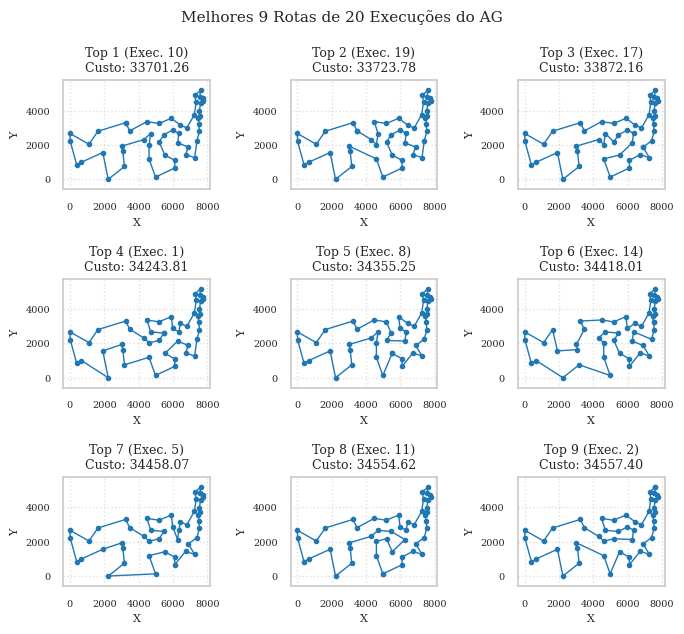

Gráfico das melhores rotas (2 colunas) salvo em 'images' como images/melhores_9_rotas_ag_2col_ieee.pdf e .png


In [70]:

# --- Importações e Configurações Iniciais para Plots IEEE (se ainda não definidas no escopo) ---
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações IEEE (ajuste conforme necessário)
largura_pagina_ieee_polegadas = 7.0  # LARGURA PARA DUAS COLUNAS
# largura_uma_coluna_ieee_pol = 3.4 # Não usado para esta figura específica

# Tamanhos de fonte (em pontos) - assumindo que estas foram definidas anteriormente
# Se não, defina-as aqui:
# fonte_titulo_figura_rotas = 11
# fonte_titulo_subplot_rotas = 9
# fonte_rotulo_eixo_rotas = 8
# fonte_ticks_rotas = 7
# plt.rcParams['font.family'] = 'serif' # Opcional
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

pasta_imagens = "images"
if not os.path.exists(pasta_imagens):
    os.makedirs(pasta_imagens)


# --- Plotar as 9 melhores rotas em formato IEEE (DUAS COLUNAS) ---
if 'resultados_para_plotar' in locals() and resultados_para_plotar:
    # Altura da figura para um grid 3x3 em duas colunas.
    # 6.8 polegadas de altura para 7 polegadas de largura dá subplots quase quadrados.
    altura_fig_rotas = 6.8
    fig_rotas, axes_rotas = plt.subplots(3, 3, figsize=(largura_pagina_ieee_polegadas, altura_fig_rotas))
    axes_rotas = axes_rotas.flatten() # Transforma array 2D de eixos em 1D

    for i, resultado in enumerate(resultados_para_plotar):
        if i < len(axes_rotas): # Segurança para não exceder o número de subplots
            ax = axes_rotas[i]
            individuo_rota = resultado['individuo']
            custo_rota = resultado['custo']
            exec_original = resultado.get('exec_num_original', i + 1) # Pega o número original da execução

            # Título do subplot indicando qual dos "melhores" é, a execução original, e o custo
            titulo_plot = f"Top {i+1} (Exec. {exec_original})\nCusto: {custo_rota:.2f}"

            if individuo_rota is None or len(individuo_rota) == 0 or not coords.any():
                ax.set_title(f"{titulo_plot}\n(Rota inválida)", fontsize=fonte_titulo_subplot_rotas)
                ax.text(0.5, 0.5, 'Sem rota', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                caminho = coords[individuo_rota] 
                caminho = np.vstack([caminho, caminho[0]]) # Volta para o início
                
                ax.plot(caminho[:, 0], caminho[:, 1], '-o', markersize=3, linewidth=1.0, color='tab:blue') # Linhas e marcadores finos
                ax.set_title(titulo_plot, fontsize=fonte_titulo_subplot_rotas)
                ax.set_xlabel("X", fontsize=fonte_rotulo_eixo_rotas)
                ax.set_ylabel("Y", fontsize=fonte_rotulo_eixo_rotas)
                ax.tick_params(axis='both', which='major', labelsize=fonte_ticks_rotas)
                ax.grid(True, linestyle=':', alpha=0.6) # Grid mais sutil
                ax.axis('equal') # Mantém a proporção dos eixos

    # Remove eixos extras se por acaso plotarmos menos que 9
    for j in range(len(resultados_para_plotar), len(axes_rotas)):
        fig_rotas.delaxes(axes_rotas[j])

    # Título geral da figura
    # Ajuste o 'y' para melhor posicionamento sobre os subplots
    fig_rotas.suptitle(f'Melhores {num_melhores_para_plotar} Rotas de {num_execucoes_total} Execuções do AG', fontsize=fonte_titulo_figura_rotas, y=0.94)
    
    # Ajustar o layout para evitar sobreposição.
    # O rect [left, bottom, right, top] pode precisar de ajuste fino.
    # Para uma figura larga, o 'top' é importante para o suptitle.
    fig_rotas.tight_layout(rect=[0, 0.01, 1, 0.96]) # Ajustado 'top' para 0.96

    nome_arquivo_rotas_2col = os.path.join(pasta_imagens, "melhores_9_rotas_ag_2col_ieee")
    plt.savefig(f"{nome_arquivo_rotas_2col}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"{nome_arquivo_rotas_2col}.png", dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Gráfico das melhores rotas (2 colunas) salvo em '{pasta_imagens}' como {nome_arquivo_rotas_2col}.pdf e .png")
else:
    print("Não foi possível gerar o gráfico das 9 melhores rotas (resultados_para_plotar não disponível/vazio).")


In [15]:
import itertools
from tqdm import tqdm
import numpy as np # Garantindo que np está acessível
import random # Garantindo que random está acessível

# Valores dos parâmetros para testar (exemplo, substitua pelos seus valores)
n_pop_valores = [20, 30, 40, 50, 60, 70]
tx_cross_valores = [0.5, 0.6, 0.7, 0.8]
tx_mut_valores = [0.005, 0.01, 0.015, 0.02, 0.04, 0.08]

n_execucoes_por_combinacao_ag = 3
n_geracoes_experimento_ag = 10000 # Novo número de gerações
# k_torneio é assumido como definido anteriormente, por exemplo: k_torneio = 2

resultados_experimentos_ag = []

combinacoes_parametros_ag = list(itertools.product(n_pop_valores, tx_cross_valores, tx_mut_valores))

for n_pop_param, tx_cross_param, tx_mut_param in tqdm(combinacoes_parametros_ag, desc="Combinações AG"):
    custos_desta_combinacao_ag = []

    for exec_idx_ag in tqdm(range(n_execucoes_por_combinacao_ag),
                              desc=f"Exec AG: Pop={n_pop_param},Cross={tx_cross_param},Mut={tx_mut_param}",
                              leave=False):
        
        populacao_ag = []
        for _ in range(n_pop_param):
            individuo = list(np.random.permutation(n_cidades))
            populacao_ag.append(individuo)

        melhor_individuo_global_exec_ag = None
        melhor_custo_global_exec_ag = float('inf')
        
        # Calcular limites de custo uma vez por execução, se eles dependerem da população ou outros fatores dinâmicos
        # Se forem fixos baseados apenas em dist_matrix e n_cidades, podem ser calculados fora do loop de execuções.
        # Para simplificar, vamos recalcular aqui, assumindo que não há grande impacto de performance.
        custo_min_teorico, custo_max_teorico = calcular_limites_custo(dist_matrix, n_cidades)
        if custo_min_teorico == custo_max_teorico: # Evitar divisão por zero
            custo_max_teorico = custo_min_teorico + 1 

        for geracao_ag in range(n_geracoes_experimento_ag):
            populacao_com_custos = []
            for ind in populacao_ag:
                custo = calcular_custo_rota(ind, dist_matrix)
                populacao_com_custos.append({'individuo': ind, 'custo_real': custo})

            populacao_com_fitness_escalonada = []
            for item in populacao_com_custos:
                # Escalonamento do fitness
                fitness_esc = (item['custo_real'] - custo_min_teorico) / (custo_max_teorico - custo_min_teorico)
                fitness_esc = np.clip(fitness_esc, 0.0, 1.0) 
                populacao_com_fitness_escalonada.append({
                    'individuo': item['individuo'],
                    'custo_real': item['custo_real'],
                    'fitness_escalonada': fitness_esc 
                })
                
                if item['custo_real'] < melhor_custo_global_exec_ag:
                    melhor_custo_global_exec_ag = item['custo_real']
                    melhor_individuo_global_exec_ag = item['individuo'][:]
            
            pais_selecionados = selecao_torneio(populacao_com_fitness_escalonada, k_torneio)
            proxima_geracao = []

            # Elitismo: Adicionar o melhor indivíduo da geração atual (se encontrado)
            # A lógica original era "if melhor_individuo_global_ag:", que se refere ao melhor global de toda a execução.
            # Para manter o elitismo mais focado na geração atual, podemos pegar o melhor da populacao_com_fitness_escalonada.
            if populacao_com_fitness_escalonada: # Garantir que a população não está vazia
                 melhor_da_geracao_atual = min(populacao_com_fitness_escalonada, key=lambda x: x['custo_real'])
                 proxima_geracao.append(melhor_da_geracao_atual['individuo'][:])


            idx_pais = 0
            while len(proxima_geracao) < n_pop_param:
                pai1_idx = idx_pais % len(pais_selecionados)
                pai2_idx = (idx_pais + 1) % len(pais_selecionados)
                
                pai1 = pais_selecionados[pai1_idx]
                pai2 = pais_selecionados[pai2_idx]
                idx_pais += 2

                filho1, filho2 = list(pai1), list(pai2) # Cópia dos pais

                if random.random() < tx_cross_param:
                    filho1, filho2 = crossover_pmx(list(pai1), list(pai2))
                
                # Aplicar mutação
                for filho_mut in [filho1, filho2]:
                    if random.random() < tx_mut_param:
                        tipo_mutacao = random.choice(['swap', 'insert', 'inversion'])
                        if tipo_mutacao == 'swap':
                            filho_mut = mutacao_swap(filho_mut)
                        elif tipo_mutacao == 'insert':
                            filho_mut = mutacao_insert(filho_mut)
                        else: # inversion
                            filho_mut = mutacao_inversion(filho_mut)
                    
                    if len(proxima_geracao) < n_pop_param:
                        proxima_geracao.append(filho_mut)
                    else:
                        break 
            
            populacao_ag = proxima_geracao
        
        custos_desta_combinacao_ag.append(melhor_custo_global_exec_ag)

    resultados_experimentos_ag.append({
        'n_populacao': n_pop_param,
        'taxa_crossover': tx_cross_param,
        'taxa_mutacao': tx_mut_param,
        'custos_execucoes': custos_desta_combinacao_ag,
        'melhor_custo_combinacao': min(custos_desta_combinacao_ag) if custos_desta_combinacao_ag else float('inf'),
        'media_custo_combinacao': np.mean(custos_desta_combinacao_ag) if custos_desta_combinacao_ag else float('inf'),
        'std_custo_combinacao': np.std(custos_desta_combinacao_ag) if custos_desta_combinacao_ag else float('inf')
    })

print("\n--- Resultados dos Experimentos AG ---")
for res_ag in resultados_experimentos_ag:
    print(f"Params: Pop={res_ag['n_populacao']}, Cross={res_ag['taxa_crossover']}, Mut={res_ag['taxa_mutacao']}")
    print(f"  Melhor Custo (min execs): {res_ag['melhor_custo_combinacao']:.2f}")
    print(f"  Média Custos: {res_ag['media_custo_combinacao']:.2f}, DP: {res_ag['std_custo_combinacao']:.2f}")
    print(f"  Custos execs: {[float(f'{c:.2f}') for c in res_ag['custos_execucoes']]}")
    print("-" * 30)



if resultados_experimentos_ag: # Verifica se há resultados para salvar
    df_resultados_ag = pd.DataFrame(resultados_experimentos_ag)
    
    # Opcional: Reordenar colunas para melhor visualização no CSV
    colunas_ordenadas = [
        'n_populacao', 'taxa_crossover', 'taxa_mutacao', 
        'melhor_custo_combinacao', 'media_custo_combinacao', 'std_custo_combinacao',
        'custos_execucoes'
    ]
    # Garante que apenas colunas existentes sejam selecionadas
    colunas_existentes_ordenadas = [col for col in colunas_ordenadas if col in df_resultados_ag.columns]
    df_resultados_ag = df_resultados_ag[colunas_existentes_ordenadas]

    nome_arquivo_csv_ag = 'resultados_experimentos_ag.csv'
    df_resultados_ag.to_csv(nome_arquivo_csv_ag, index=False, float_format='%.4f')
    print(f"\nResultados do AG salvos em: {nome_arquivo_csv_ag}")
else:
    print("\nNenhum resultado do AG para salvar.")



Combinações AG:   0%|          | 0/144 [00:00<?, ?it/s]

Combinações AG: 100%|██████████| 144/144 [49:06<00:00, 20.46s/it]


--- Resultados dos Experimentos AG ---
Params: Pop=20, Cross=0.5, Mut=0.005
  Melhor Custo (min execs): 45435.25
  Média Custos: 46388.08, DP: 1292.37
  Custos execs: [45435.25, 48215.2, 45513.78]
------------------------------
Params: Pop=20, Cross=0.5, Mut=0.01
  Melhor Custo (min execs): 37549.36
  Média Custos: 39127.84, DP: 1418.24
  Custos execs: [38845.43, 40988.72, 37549.36]
------------------------------
Params: Pop=20, Cross=0.5, Mut=0.015
  Melhor Custo (min execs): 36885.02
  Média Custos: 37803.11, DP: 1022.26
  Custos execs: [39229.29, 36885.02, 37295.02]
------------------------------
Params: Pop=20, Cross=0.5, Mut=0.02
  Melhor Custo (min execs): 35494.38
  Média Custos: 35902.69, DP: 497.67
  Custos execs: [36603.32, 35610.39, 35494.38]
------------------------------
Params: Pop=20, Cross=0.5, Mut=0.04
  Melhor Custo (min execs): 34963.96
  Média Custos: 35397.40, DP: 317.72
  Custos execs: [35716.69, 35511.56, 34963.96]
------------------------------
Params: Pop=20, 

In [63]:
nome_arquivo_csv_ag = 'resultados_experimentos_ag.csv'
df_resultados_ag = pd.read_csv(nome_arquivo_csv_ag)

/tmp/ipykernel_6389/3331911077.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=param_col, y='melhor_custo_combinacao', data=df_resultados_ag, ax=ax_boxplot, palette="viridis", linewidth=0.7, fliersize=2) # Linha e outliers menores
/tmp/ipykernel_6389/3331911077.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=param_col, y='melhor_custo_combinacao', data=df_resultados_ag, ax=ax_boxplot, palette="viridis", linewidth=0.7, fliersize=2) # Linha e outliers menores
/tmp/ipykernel_6389/3331911077.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

 

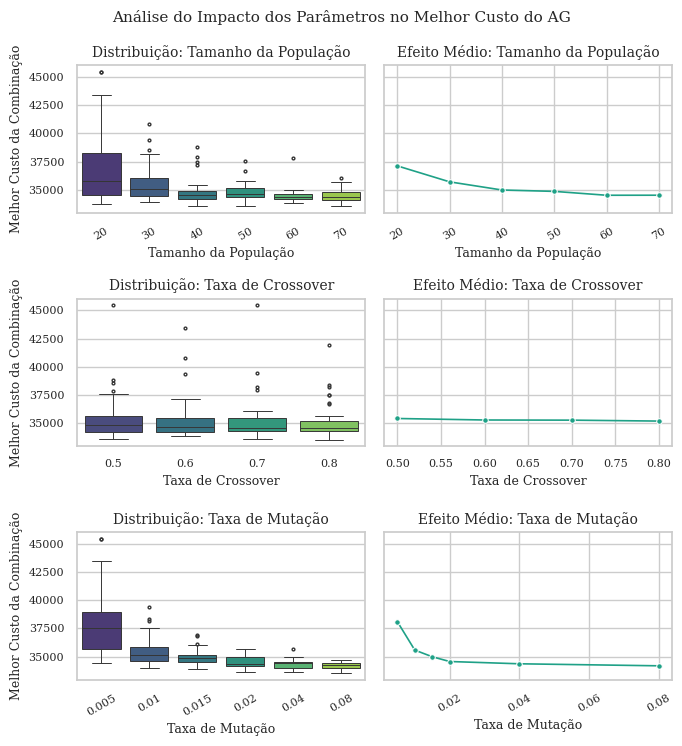

Gráfico principal salvo em 'images' como images/analise_parametros_ag_ieee.pdf e .png


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 


# --- Configurações para formato IEEE (Ajustadas) ---
largura_pagina_ieee_polegadas = 7.0  # Largura para duas colunas (página inteira)

# Tamanhos de fonte (em pontos) - AUMENTADOS
fonte_titulo_figura = 11
fonte_titulo_subplot = 10
fonte_rotulo_eixo = 9
fonte_ticks = 8
# Descomente e ajuste se quiser usar fontes serifadas como Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Criar pasta de imagens se não existir
pasta_imagens = "images"
if not os.path.exists(pasta_imagens):
    os.makedirs(pasta_imagens)

# Lista dos parâmetros principais e seus nomes para os títulos
parametros_para_plotar = [
    ('n_populacao', 'Tamanho da População'),
    ('taxa_crossover', 'Taxa de Crossover'),
    ('taxa_mutacao', 'Taxa de Mutação')
]

# --- Figura Principal (3 linhas, 2 colunas) ---
# Ajustar figsize: largura da página, altura REDUZIDA
altura_fig_principal = 8.0 # Era 9.0, ajuste conforme necessário
fig, axes = plt.subplots(3, 2, figsize=(largura_pagina_ieee_polegadas, altura_fig_principal), sharey='row')
fig.suptitle('Análise do Impacto dos Parâmetros no Melhor Custo do AG', fontsize=fonte_titulo_figura, y=0.94) # y ajustado

# Loop através dos parâmetros para criar os plots
for i, (param_col, param_nome) in enumerate(parametros_para_plotar):
    
    ax_boxplot = axes[i, 0]
    sns.boxplot(x=param_col, y='melhor_custo_combinacao', data=df_resultados_ag, ax=ax_boxplot, palette="viridis", linewidth=0.7, fliersize=2) # Linha e outliers menores
    ax_boxplot.set_title(f'Distribuição: {param_nome}', fontsize=fonte_titulo_subplot)
    ax_boxplot.set_xlabel(param_nome, fontsize=fonte_rotulo_eixo)
    ax_boxplot.set_ylabel('Melhor Custo da Combinação', fontsize=fonte_rotulo_eixo)
    ax_boxplot.tick_params(axis='x', labelsize=fonte_ticks, rotation=30 if df_resultados_ag[param_col].dtype == 'object' or df_resultados_ag[param_col].nunique() > 4 else 0)
    ax_boxplot.tick_params(axis='y', labelsize=fonte_ticks)

    ax_lineplot = axes[i, 1]
    df_grouped = df_resultados_ag.groupby(param_col)['melhor_custo_combinacao'].mean().reset_index()
    sns.lineplot(x=param_col, y='melhor_custo_combinacao', data=df_grouped, marker='o', markersize=4, linewidth=1.2, ax=ax_lineplot, errorbar=('ci', 95), color=sns.color_palette("viridis")[3])
    ax_lineplot.set_title(f'Efeito Médio: {param_nome}', fontsize=fonte_titulo_subplot)
    ax_lineplot.set_xlabel(param_nome, fontsize=fonte_rotulo_eixo)
    ax_lineplot.tick_params(axis='x', labelsize=fonte_ticks, rotation=30 if df_resultados_ag[param_col].dtype == 'object' or df_resultados_ag[param_col].nunique() > 4 else 0)
    ax_lineplot.tick_params(axis='y', labelsize=fonte_ticks)
    
    if i > 0 or not ax_boxplot.get_ylabel(): # Se o ylabel do boxplot foi removido por sharey (não é o caso aqui, mas seguro)
        ax_lineplot.set_ylabel("") # Remove y_label dos plots da direita, exceto o primeiro
    else:
        ax_lineplot.set_ylabel('Média do Melhor Custo', fontsize=fonte_rotulo_eixo)


# Ajustar o layout para evitar sobreposição
fig.tight_layout(rect=[0, 0.01, 1, 0.96]) # rect ajusta para o suptitle e eixos
nome_arquivo_principal = os.path.join(pasta_imagens, "analise_parametros_ag_ieee")
plt.savefig(f"{nome_arquivo_principal}.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"{nome_arquivo_principal}.png", dpi=600, bbox_inches='tight')
plt.show()
print(f"Gráfico principal salvo em '{pasta_imagens}' como {nome_arquivo_principal}.pdf e .png")


# --- Figura Extra (se existir e se for usada) ---
if 'max_ger_sem_melhoria' in df_resultados_ag.columns:
    altura_fig_extra = 3.2 # Era 3.5, ajuste conforme necessário
    fig_extra, axes_extra = plt.subplots(1, 2, figsize=(largura_pagina_ieee_polegadas, altura_fig_extra), sharey=True)
    fig_extra.suptitle('Análise: Max Gerações Sem Melhoria', fontsize=fonte_titulo_figura, y=0.98) # y ajustado

    param_col_extra = 'max_ger_sem_melhoria'
    param_nome_extra = 'Max Ger. Sem Melhoria'

    sns.boxplot(x=param_col_extra, y='melhor_custo_combinacao', data=df_resultados_ag, ax=axes_extra[0], palette="viridis", linewidth=0.7, fliersize=2)
    axes_extra[0].set_title(f'Distribuição: {param_nome_extra}', fontsize=fonte_titulo_subplot)
    axes_extra[0].set_xlabel(param_nome_extra, fontsize=fonte_rotulo_eixo)
    axes_extra[0].set_ylabel('Melhor Custo da Combinação', fontsize=fonte_rotulo_eixo)
    axes_extra[0].tick_params(axis='both', labelsize=fonte_ticks)

    df_grouped_extra = df_resultados_ag.groupby(param_col_extra)['melhor_custo_combinacao'].mean().reset_index()
    sns.lineplot(x=param_col_extra, y='melhor_custo_combinacao', data=df_grouped_extra, marker='o', markersize=4, linewidth=1.2, ax=axes_extra[1], errorbar=('ci', 95), color=sns.color_palette("viridis")[3])
    axes_extra[1].set_title(f'Efeito Médio: {param_nome_extra}', fontsize=fonte_titulo_subplot)
    axes_extra[1].set_xlabel(param_nome_extra, fontsize=fonte_rotulo_eixo)
    axes_extra[1].tick_params(axis='both', labelsize=fonte_ticks)
    axes_extra[1].set_ylabel("")

    fig_extra.tight_layout(rect=[0, 0.02, 1, 0.94]) # Ajustar rect para esta figura
    nome_arquivo_extra = os.path.join(pasta_imagens, "analise_max_ger_sem_melhoria_ieee")
    plt.savefig(f"{nome_arquivo_extra}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"{nome_arquivo_extra}.png", dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Gráfico extra salvo em '{pasta_imagens}' como {nome_arquivo_extra}.pdf e .png")
